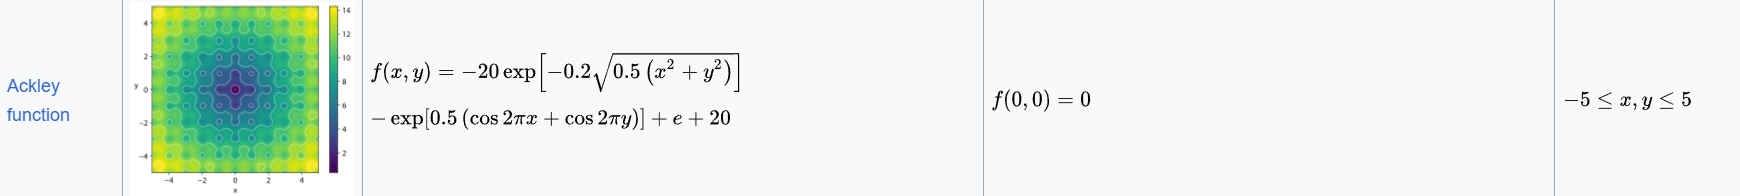

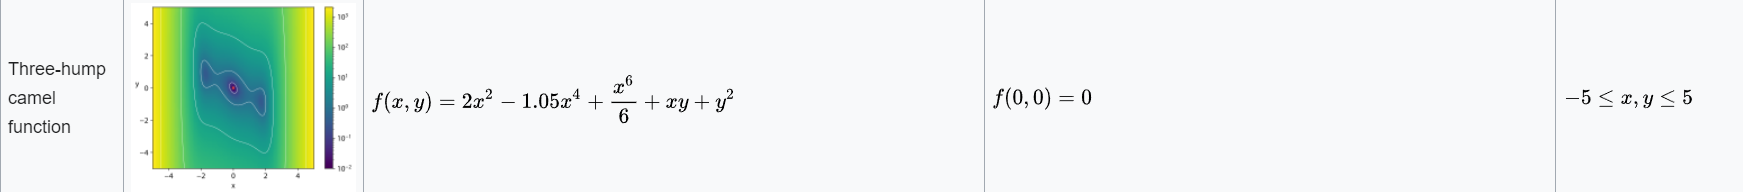

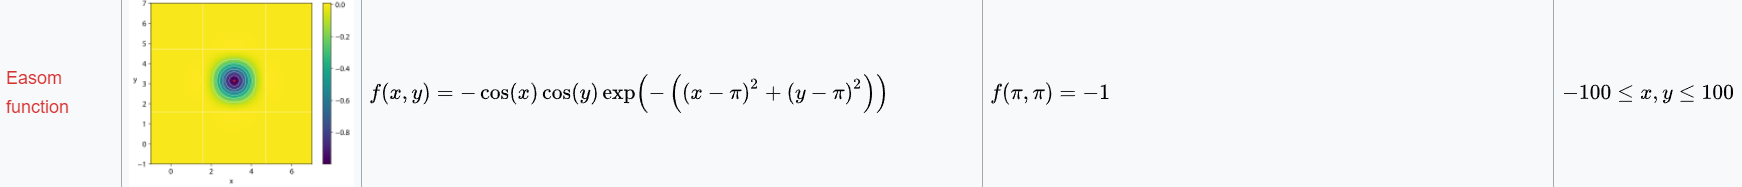

In [12]:
import math


def easom(array):
    x, y = array
    return (
        -math.cos(x)
        * math.cos(y)
        * math.exp(-((x - math.pi) ** 2 + (y - math.pi) ** 2))
    )


def ackley(array):
    x, y = array
    term1 = -20 * math.exp(-0.2 * math.sqrt(0.5 * (x**2 + y**2)))
    term2 = -math.exp(0.5 * (math.cos(2 * math.pi * x) + math.cos(2 * math.pi * y)))
    return term1 + term2 + math.e + 20


def camel(array):
    x, y = array
    return 2 * x**2 - 1.05 * x**4 + (x**6 / 6) + x * y + y**2

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.spatial.distance import hamming

LIMITS = {
    "Easom": [(-100, 100), (-100, 100)],
    "Ackley": [(-5, 5), (-5, 5)],
    "Three-Hump Camel": [(-5, 5), (-5, 5)],
}


def initialize_population(pop_size, limits):
    return [[random.uniform(lim[0], lim[1]) for lim in limits] for _ in range(pop_size)]


def float_to_bin(value, min_val, max_val, n_bits=16):
    scaled_value = int(((value - min_val) / (max_val - min_val)) * (2**n_bits - 1))
    return format(scaled_value, f"0{n_bits}b")


def bin_to_float(binary_string, min_val, max_val, n_bits=16):
    int_value = int(binary_string, 2)
    return min_val + (int_value / (2**n_bits - 1)) * (max_val - min_val)


# binary string representation
def encode_individual(individual, limits, n_bits=16):
    binary_individual = ""
    for i, value in enumerate(individual):
        binary_individual += float_to_bin(value, limits[i][0], limits[i][1], n_bits)
    return binary_individual


def decode_individual(binary_individual, limits, n_bits=16):
    individual = []
    for i, lim in enumerate(limits):
        binary_value = binary_individual[i * n_bits : (i + 1) * n_bits]
        individual.append(bin_to_float(binary_value, lim[0], lim[1], n_bits))
    return individual


def crossover(parent1, parent2, crossover_type="SP"):
    length = len(parent1)

    if crossover_type == "SP":
        point = random.randint(1, length - 1)
        return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

    elif crossover_type == "TP":
        pt1, pt2 = sorted(random.sample(range(1, length), 2))
        return (
            parent1[:pt1] + parent2[pt1:pt2] + parent1[pt2:],
            parent2[:pt1] + parent1[pt1:pt2] + parent2[pt2:],
        )


def mutate(individual, mutation_rate):
    mutated = "".join(
        char if random.random() > mutation_rate else str(1 - int(char))
        for char in individual
    )
    return mutated


def invert(individual, inversion_rate):
    if random.random() < inversion_rate:
        length = len(individual)
        pt1, pt2 = sorted(random.sample(range(length), 2))
        return individual[:pt1] + individual[pt1:pt2][::-1] + individual[pt2:]
    return individual


# fitness of the population
def evaluate_population(population, func):
    return [func(individual) for individual in population]


# Parent Selection
# Inbreeding (ID), Outbreeding (OD), Panmixia (PM), Selective (SE)
def hamming_distance(ind1, ind2):
    return hamming(list(ind1), list(ind2))


def select_parents(population, fitness, method):
    if method == "PM":  # Panmixia
        return random.sample(population, k=2)
    elif (
        method == "SE"
    ):  # Selective based on fitness: Parents with fitness below average fitness
        avg_fitness = np.mean(fitness)
        parents = [ind for ind, fit in zip(population, fitness) if fit < avg_fitness]
        if len(parents) < 2:
            if len(parents) == 0:
                return random.sample(
                    population, k=2
                )  # Fallback to random sampling from the entire population
            else:
                # return parents[0], parents[0]
                return parents[0], random.choice(population)
        return random.sample(parents, k=2)
    elif method == "ID":  # Inbreeding
        parent1 = random.choice(population)
        parent2 = min(population, key=lambda x: hamming_distance(parent1, x))
        return parent1, parent2
    elif method == "OD":  # Outbreeding
        parent1 = random.choice(population)
        parent2 = max(population, key=lambda x: hamming_distance(parent1, x))
        return parent1, parent2


# Children Selection
# Simple selection (SS), Selection with displacement (SD), Elite selection (ES)
def form_new_population(population, offspring, method, fitness_func):
    if method == "SS":  # Simple selection
        return offspring
    elif method == "SD":  # Selection with displacement (unique individuals)
        # Convert lists to tuples to make them hashable for set operations
        unique_offspring = list(map(tuple, offspring))
        unique_offspring = list(set(unique_offspring))
        unique_offspring = list(map(list, unique_offspring))

        if len(unique_offspring) < len(population):
            additional_offspring = random.sample(
                offspring, len(population) - len(unique_offspring)
            )
            unique_offspring.extend(additional_offspring)

        return random.sample(unique_offspring, len(population))
    elif method == "ES":  # Elite selection
        combined = population + offspring
        combined_fitness = evaluate_population(combined, fitness_func)
        elite_indices = np.argsort(combined_fitness)[: len(population)]
        return [combined[i] for i in elite_indices]


# Stopping Criteria
def stopping_criteria(
    population, fitness, iteration, max_iterations, criteria_type, threshold=0.01
):
    if criteria_type == "fixed":
        return iteration >= max_iterations
    elif criteria_type == "max_distance":
        distances = [
            hamming(list(ind1), list(ind2))
            for ind1 in population
            for ind2 in population
        ]
        return max(distances) < threshold
    elif criteria_type == "fitness_convergence":
        return abs(np.mean(fitness) - np.mean(fitness[-2])) < threshold


def process_children(
    parent1, parent2, crossover_type, mutation_rate, inversion_rate, crossover_chance
):
    if random.random() < crossover_chance:
        child1, child2 = crossover(parent1, parent2, crossover_type)
    else:
        child1, child2 = parent1, parent2

    child1 = mutate(child1, mutation_rate)
    child2 = mutate(child2, mutation_rate)

    child1 = invert(child1, inversion_rate)
    child2 = invert(child2, inversion_rate)

    return child1, child2


# Genetic Algorithm
def genetic_algorithm(
    func,
    limits,
    pop_size,
    n_bits=16,
    max_iterations=300,
    crossover_type="SP",
    mutation_rate=0.01,
    inversion_rate=0.5,
    parent_selection_method="PM",
    population_formation="SS",
    stopping_type="fixed",
    stop_threshold=0.01,
):
    CROSSOVER_CHANCE = 0.8
    # Initialize population in floating point numbers
    population = initialize_population(pop_size, limits)

    # Encode population as binary strings
    binary_population = [encode_individual(ind, limits, n_bits) for ind in population]

    fitness = evaluate_population(population, func)
    iteration = 0
    fitness_history = []
    best_solution_history = []
    children = []

    while not stopping_criteria(
        population, fitness, iteration, max_iterations, stopping_type, stop_threshold
    ):
        for _ in range(pop_size // 2):
            # Parent selection
            parent1, parent2 = select_parents(
                binary_population, fitness, parent_selection_method
            )

            # (crossover, mutation, inversion)
            child1, child2 = process_children(
                parent1,
                parent2,
                crossover_type,
                mutation_rate,
                inversion_rate,
                CROSSOVER_CHANCE,
            )

            # convert back to float
            decoded_child1 = decode_individual(child1, limits, n_bits)
            decoded_child2 = decode_individual(child2, limits, n_bits)

            children.append(decoded_child1)
            children.append(decoded_child2)

        # Children selection for new population
        population = form_new_population(
            population, children, population_formation, func
        )

        # Evaluate fitness for the new population
        fitness = evaluate_population(population, func)

        current_best = min(fitness)

        # the best solution for the current iteration
        best_solution_history.append(population[fitness.index(current_best)])

        # print(
        #     f"Iteration {iteration + 1}: Best Fitness = {current_best}, Solution = {population[fitness.index(current_best)]}"
        # )

        fitness_history.append(current_best)
        iteration += 1

    overall_best = min(fitness_history)
    best_overall_solution = best_solution_history[fitness_history.index(overall_best)]

    # print(
    #     f"Overall Best Solution: {best_overall_solution} with Fitness = {overall_best}"
    # )
    # print("-" * 100)
    # print("\n")

    return best_overall_solution, overall_best, fitness_history

In [14]:
def plot_fitness_history(fitness_histories, labels, title):
    plt.figure(figsize=(10, 6))

    for fitness_history, label in zip(fitness_histories, labels):
        plt.plot(fitness_history, label=label)

    plt.xlabel("Generations")
    plt.ylabel("Minimum Function Value")
    plt.title(title)
    plt.legend()
    plt.show()

<h2> Crossover

In [53]:
import time


# Function to test crossover types
def test_crossover(func, limits, pop_size=200):
    results = {}

    # Test single-point crossover
    start_time = time.time()
    best_solution_sp, min_sp, fitness_history_sp = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="PM",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_sp = time.time() - start_time

    # Store results for single-point crossover
    results["Single-Point"] = {
        "Best Solution": best_solution_sp,
        "F_min": min_sp,
        "Time Taken (s)": execution_time_sp,
        "Fitness History": fitness_history_sp,
    }

    # Test two-point crossover
    start_time = time.time()
    best_solution_tp, min_tp, fitness_history_tp = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="TP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="PM",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_tp = time.time() - start_time

    # Store results for two-point crossover
    results["Two-Point"] = {
        "Best Solution": best_solution_tp,
        "F_min": min_tp,
        "Time Taken (s)": execution_time_tp,
        "Fitness History": fitness_history_tp,
    }

    return results

In [35]:
from prettytable import PrettyTable


def print_results(results, function_name):
    table = PrettyTable()
    headers = ["  ", "Best Solution", "F_min", "Time Taken (s)"]
    table.field_names = headers

    for key, result in results.items():
        row_data = [key] + [result[header] for header in headers[1:]]
        table.add_row(row_data)

    print(f"\nResults for {function_name}:\n")
    print(table)

In [58]:
# crossover
easom_crossover = test_crossover(easom, LIMITS["Easom"])
print_results(
    easom_crossover,
    "Easom",
)

ackley_crossover = test_crossover(ackley, LIMITS["Ackley"])
print_results(
    ackley_crossover,
    "Ackley",
)

camel_crossover = test_crossover(camel, LIMITS["Three-Hump Camel"])
print_results(
    camel_crossover,
    "Three-Hump Camel",
)


Results for Easom:

+--------------+------------------------------------------+-------------------------+-------------------+
|              |              Best Solution               |          F_min          |   Time Taken (s)  |
+--------------+------------------------------------------+-------------------------+-------------------+
| Single-Point | [1.1917296101319863, 0.8133058670939164] | -2.5109414419989915e-05 | 2.505321502685547 |
|  Two-Point   | [3.6667429617761655, 3.358510719462899]  |   -0.6118376632397368   | 2.444912910461426 |
+--------------+------------------------------------------+-------------------------+-------------------+

Results for Ackley:

+--------------+-----------------------------------------------+---------------------+--------------------+
|              |                 Best Solution                 |        F_min        |   Time Taken (s)   |
+--------------+-----------------------------------------------+---------------------+-------------------

In [59]:
def plot_fitness_histories(results, function_name, operation_type):
    fitness_histories = [
        results[op_type]["Fitness History"] for op_type in results.keys()
    ]

    plot_fitness_history(
        fitness_histories,
        labels=list(results.keys()),
        title=f"{function_name} - {operation_type}",
    )

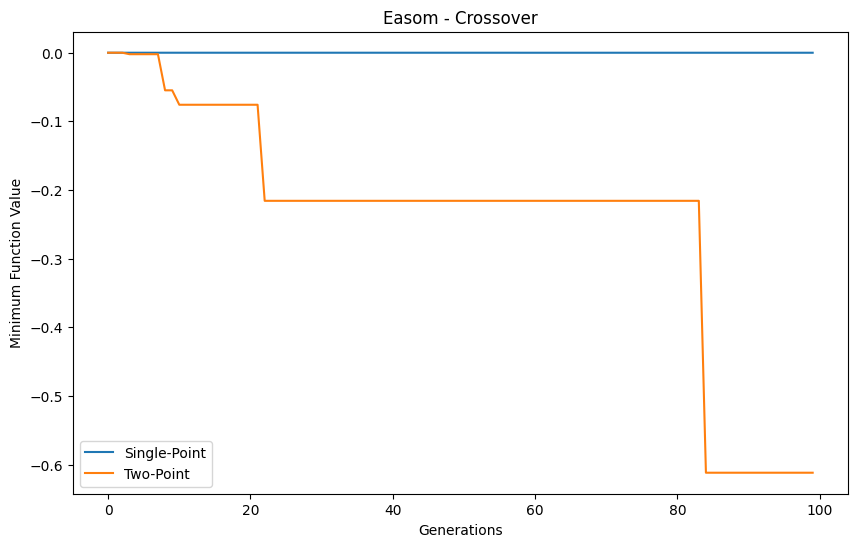

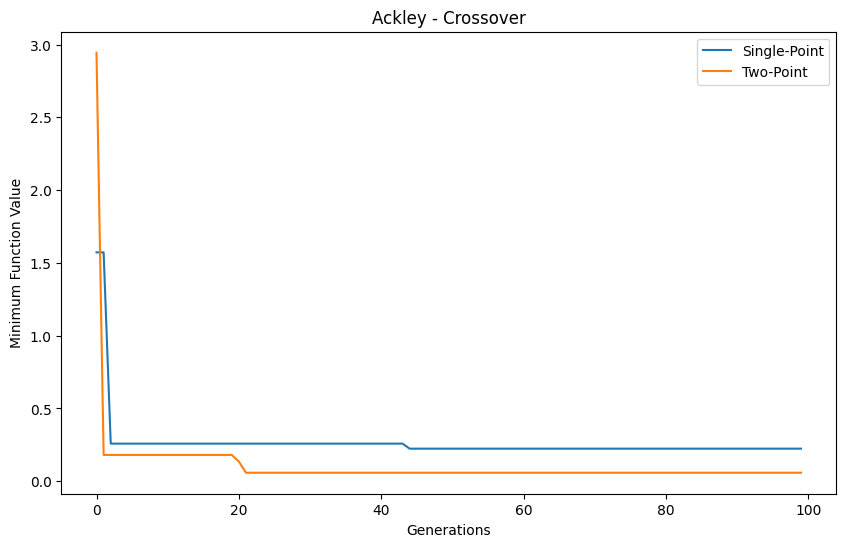

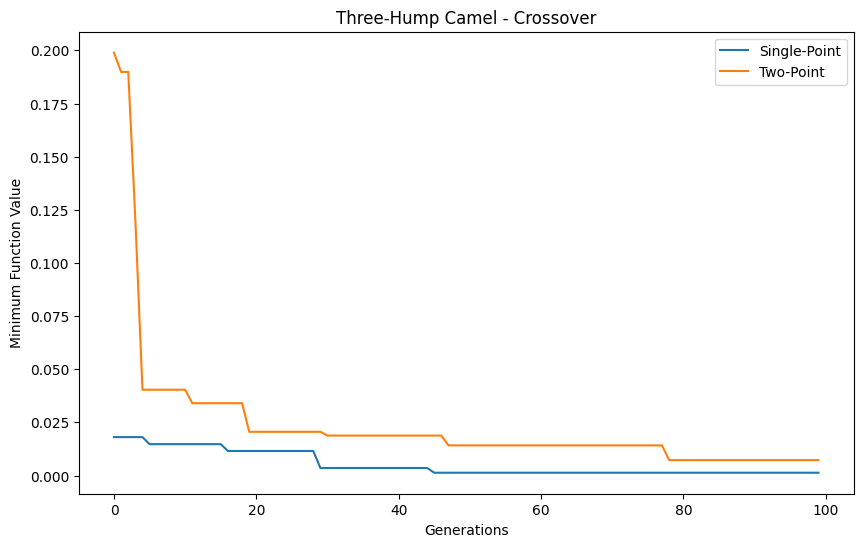

In [60]:
plot_fitness_histories(easom_crossover, "Easom", "Crossover")
plot_fitness_histories(ackley_crossover, "Ackley", "Crossover")
plot_fitness_histories(camel_crossover, "Three-Hump Camel", "Crossover")

<h2> Mutation

In [28]:
import time


# Function to test crossover types
def test_mutation(func, limits, pop_size=100):
    results = {}

    # mutation = 0.001
    start_time = time.time()
    best_solution_m1, min_m1, fitness_history_m1 = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.001,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="SS",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_sp = time.time() - start_time

    results["M1"] = {
        "Best Solution": best_solution_m1,
        "F_min": min_m1,
        "Time Taken (s)": execution_time_sp,
        "Fitness History": fitness_history_m1,
    }

    # mutation = 0.05
    start_time = time.time()
    best_solution_m2, min_m2, fitness_history_m2 = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.05,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="SS",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_tp = time.time() - start_time

    results["M2"] = {
        "Best Solution": best_solution_m2,
        "F_min": min_m2,
        "Time Taken (s)": execution_time_tp,
        "Fitness History": fitness_history_m2,
    }

    # mutation = 0.01
    start_time = time.time()
    best_solution_m3, min_m3, fitness_history_m3 = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="SS",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_tp = time.time() - start_time

    results["M3"] = {
        "Best Solution": best_solution_m3,
        "F_min": min_m3,
        "Time Taken (s)": execution_time_tp,
        "Fitness History": fitness_history_m3,
    }

    return results


Results for Easom:

+----+------------------------------------------+-------------------------+--------------------+
|    |              Best Solution               |          F_min          |   Time Taken (s)   |
+----+------------------------------------------+-------------------------+--------------------+
| M1 | [1.1620132953771503, 0.8845465958315231] | -3.0681727743086225e-05 | 2.1045470237731934 |
| M2 | [3.924655519408333, 1.6480475900806653]  |  -0.003183433713122045  | 2.0460987091064453 |
| M3 | [12.207423362929234, 6.7455336700066795] |  -3.873346971473277e-42 | 2.058128833770752  |
+----+------------------------------------------+-------------------------+--------------------+

Results for Ackley:

+----+-----------------------------------------------+--------------------+-------------------+
|    |                 Best Solution                 |       F_min        |   Time Taken (s)  |
+----+-----------------------------------------------+--------------------+-----------

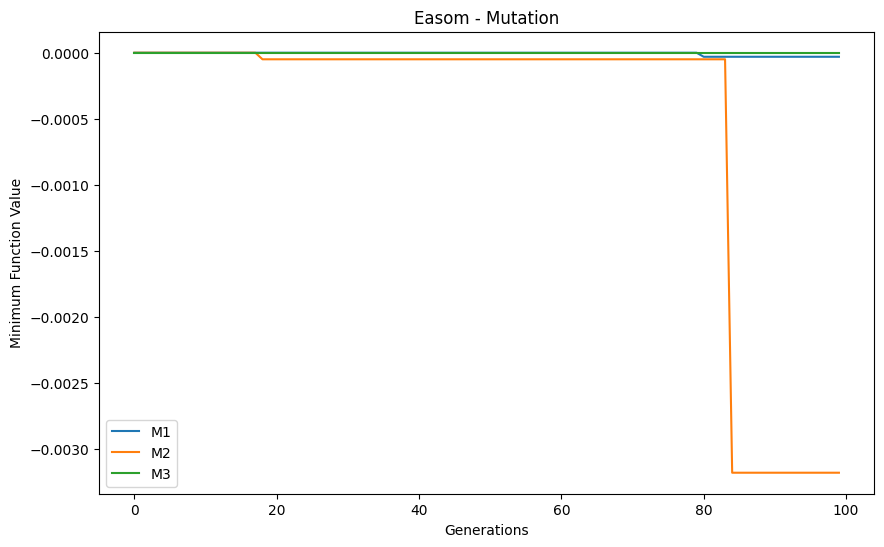

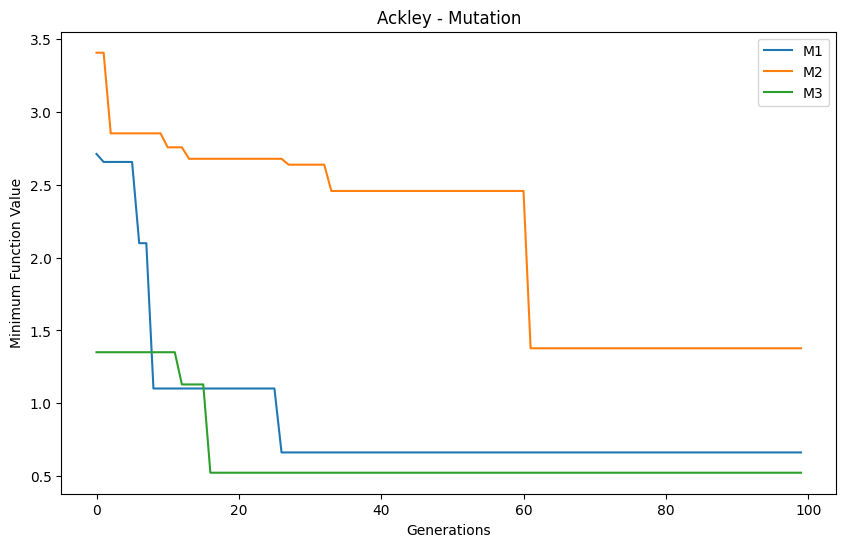

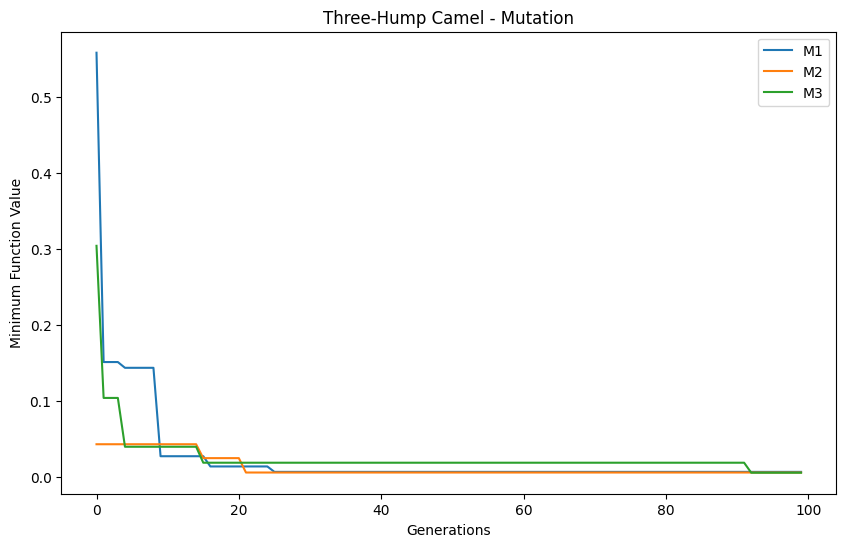

In [29]:
# mutation
easom_mutation = test_mutation(easom, LIMITS["Easom"])
print_results(
    easom_mutation,
    "Easom",
)

ackley_mutation = test_mutation(ackley, LIMITS["Ackley"])
print_results(
    ackley_mutation,
    "Ackley",
)

camel_mutation = test_mutation(camel, LIMITS["Three-Hump Camel"])
print_results(
    camel_mutation,
    "Three-Hump Camel",
)

plot_fitness_histories(easom_mutation, "Easom", "Mutation")
plot_fitness_histories(ackley_mutation, "Ackley", "Mutation")
plot_fitness_histories(camel_mutation, "Three-Hump Camel", "Mutation")

In [20]:
easom_mutation = test_mutation(easom, LIMITS["Easom"])
print(f"{'Mutation':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for mutation_type, result in easom_mutation.items():
    print(
        f"{mutation_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

ValueError: too many values to unpack (expected 2)

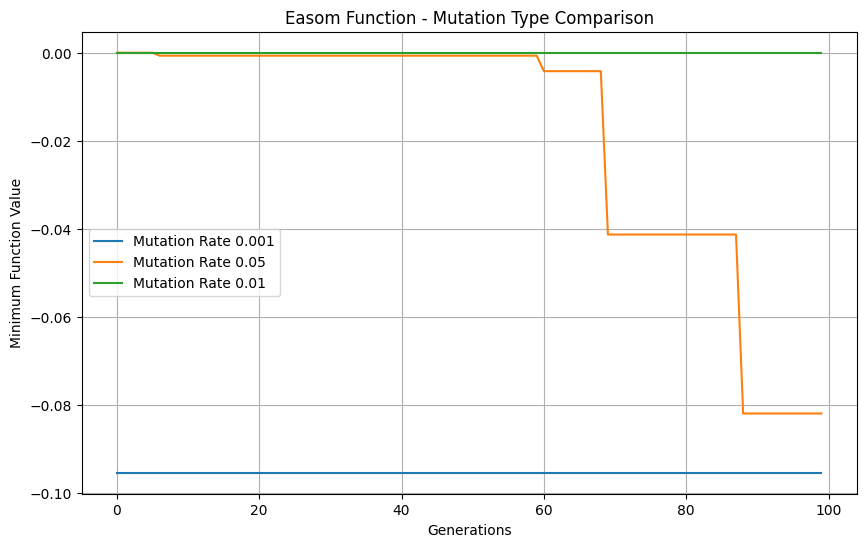

In [67]:
fitness_histories = [
    easom_mutation["M1"]["Fitness History"],
    easom_mutation["M2"]["Fitness History"],
    easom_mutation["M3"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Mutation Rate 0.001", "Mutation Rate 0.05", "Mutation Rate 0.01"],
    title="Easom Function - Mutation Type Comparison",
)

<h3>Ackley

In [51]:
ackley_mutation = test_mutation(ackley, LIMITS["Ackley"])
print(f"{'Mutation':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for mutation_type, result in ackley_mutation.items():
    print(
        f"{mutation_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Iteration 1: Best Fitness = 0.6414698508727597, Solution = [-0.1091783016708634, -0.035019455252918164]
Iteration 2: Best Fitness = 0.6414698508727597, Solution = [-0.1091783016708634, -0.035019455252918164]
Iteration 3: Best Fitness = 0.6414698508727597, Solution = [-0.1091783016708634, -0.035019455252918164]
Iteration 4: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 5: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 6: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 7: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 8: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 9: Best Fitness = 0.13700147688974695, Solution = [-0.009231708247501302, -0.035019455252918164]
Iteration 10: Best Fitness = 0.137001476889746

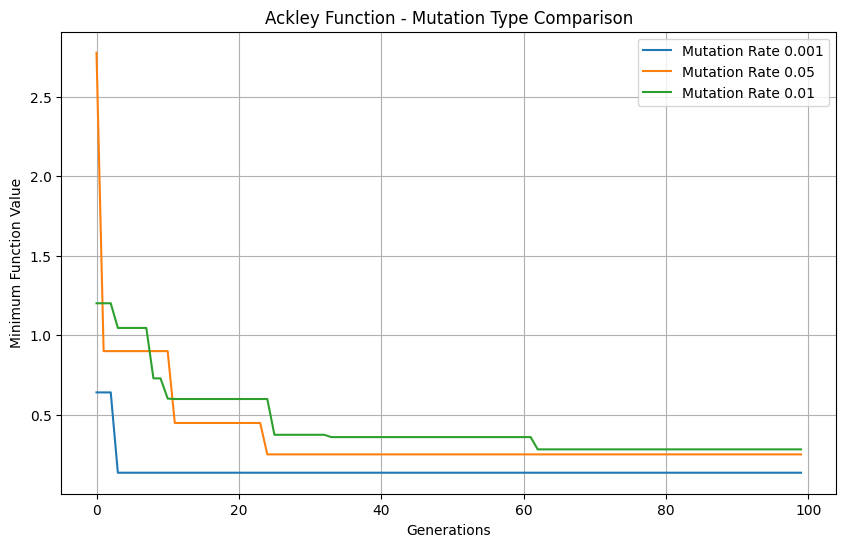

In [68]:
fitness_histories = [
    ackley_mutation["M1"]["Fitness History"],
    ackley_mutation["M2"]["Fitness History"],
    ackley_mutation["M3"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Mutation Rate 0.001", "Mutation Rate 0.05", "Mutation Rate 0.01"],
    title="Ackley Function - Mutation Type Comparison",
)

<h3> Three-hump Camel

In [46]:
camel_mutation = test_mutation(camel, LIMITS["Three-Hump Camel"])
print(f"{'Mutation':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for mutation_type, result in camel_mutation.items():
    print(
        f"{mutation_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Iteration 1: Best Fitness = 0.20816138513639698, Solution = [0.3196002136263063, 0.04066529335469582]
Iteration 2: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 3: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 4: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 5: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 6: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 7: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 8: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 9: Best Fitness = 0.008514591112374027, Solution = [0.05897611963073146, 0.01991302357518876]
Iteration 10: Best Fitness = 0.008514591112374027, Solution = [0.0

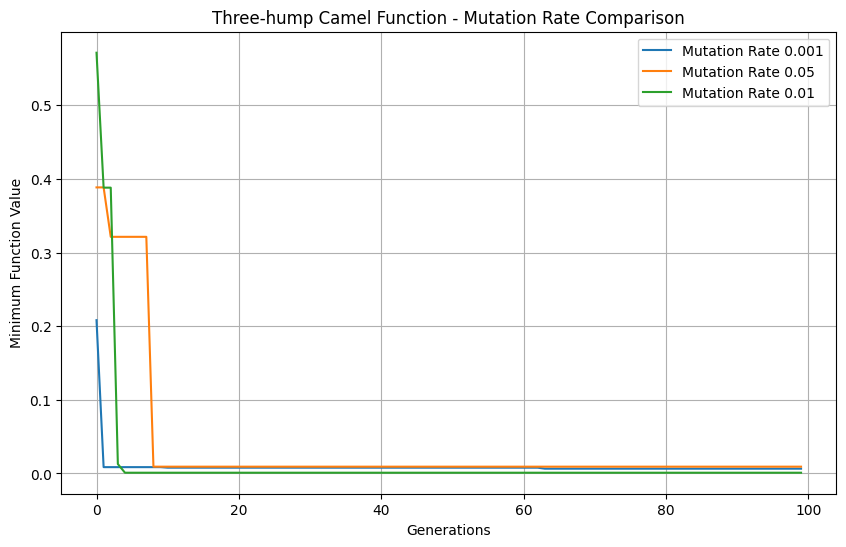

In [69]:
# Extract fitness histories for plotting
fitness_histories = [
    camel_mutation["M1"]["Fitness History"],
    camel_mutation["M2"]["Fitness History"],
    camel_mutation["M3"]["Fitness History"],
]

# Plot mutation comparison for Easom function
plot_fitness_history(
    fitness_histories,
    labels=["Mutation Rate 0.001", "Mutation Rate 0.05", "Mutation Rate 0.01"],
    title="Three-hump Camel Function - Mutation Rate Comparison",
)

<h2>Parents Selection

In [73]:
# Function to test crossover types
def test_parents(func, limits, pop_size=100):
    results = {}

    # panmixia
    start_time = time.time()
    best_solution_pm, fitness_history_pm = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="PM",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_pm = time.time() - start_time

    results["Panmixia"] = {
        "Best Solution": best_solution_pm,
        "Time Taken (s)": execution_time_pm,
        "Fitness History": fitness_history_pm,
    }

    # inbreeding
    start_time = time.time()
    best_solution_id, fitness_history_id = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="ID",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_id = time.time() - start_time

    results["Inbreeding"] = {
        "Best Solution": best_solution_id,
        "Time Taken (s)": execution_time_id,
        "Fitness History": fitness_history_id,
    }

    # outbreeding
    start_time = time.time()
    best_solution_od, fitness_history_od = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="OD",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_od = time.time() - start_time

    results["Outbreeding"] = {
        "Best Solution": best_solution_od,
        "Time Taken (s)": execution_time_od,
        "Fitness History": fitness_history_od,
    }

    # selective
    start_time = time.time()
    best_solution_se, fitness_history_se = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_se = time.time() - start_time

    results["Selective"] = {
        "Best Solution": best_solution_se,
        "Time Taken (s)": execution_time_se,
        "Fitness History": fitness_history_se,
    }

    return results

<h3>Easom

In [74]:
easom_parents = test_parents(easom, LIMITS["Easom"])
print(f"{'Parents Selection':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for parents_type, result in easom_parents.items():
    print(
        f"{parents_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Iteration 1: Best Fitness = -1.5763615455588457e-54, Solution = [-7.3929961089494185, 6.6117341878385645]
Iteration 2: Best Fitness = -1.5763615455588457e-54, Solution = [-7.3929961089494185, 6.6117341878385645]
Iteration 3: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 4: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 5: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 6: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 7: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 8: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 9: Best Fitness = -1.6307774419890277e-40, Solution = [-3.2639047837033672, -3.9444571602960252]
Iteration 10: Best Fitness = -1.6307774

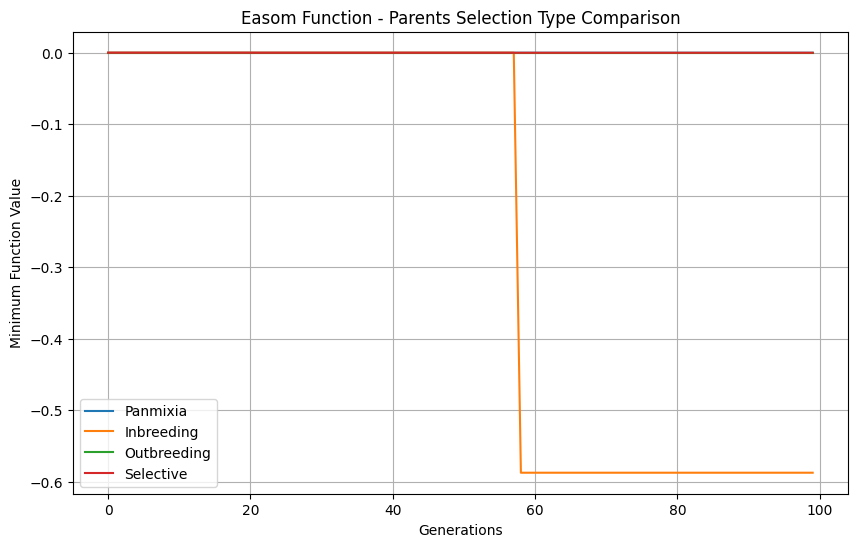

In [75]:
fitness_histories = [
    easom_parents["Panmixia"]["Fitness History"],
    easom_parents["Inbreeding"]["Fitness History"],
    easom_parents["Outbreeding"]["Fitness History"],
    easom_parents["Selective"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Panmixia", "Inbreeding", "Outbreeding", "Selective"],
    title="Easom Function - Parents Selection Type Comparison",
)

<h3>Ackley

In [76]:
ackley_parents = test_parents(ackley, LIMITS["Ackley"])
print(f"{'Parents Selection':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for parents_type, result in ackley_parents.items():
    print(
        f"{parents_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Iteration 1: Best Fitness = 2.07344236633541, Solution = [-0.08725283482871582, 0.27108290365577226]
Iteration 2: Best Fitness = 2.07344236633541, Solution = [-0.08725283482871582, 0.27108290365577226]
Iteration 3: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 4: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 5: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 6: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 7: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 8: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 9: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0.2527656977187762]
Iteration 10: Best Fitness = 1.9418632357332406, Solution = [-0.08735790035858759, 0

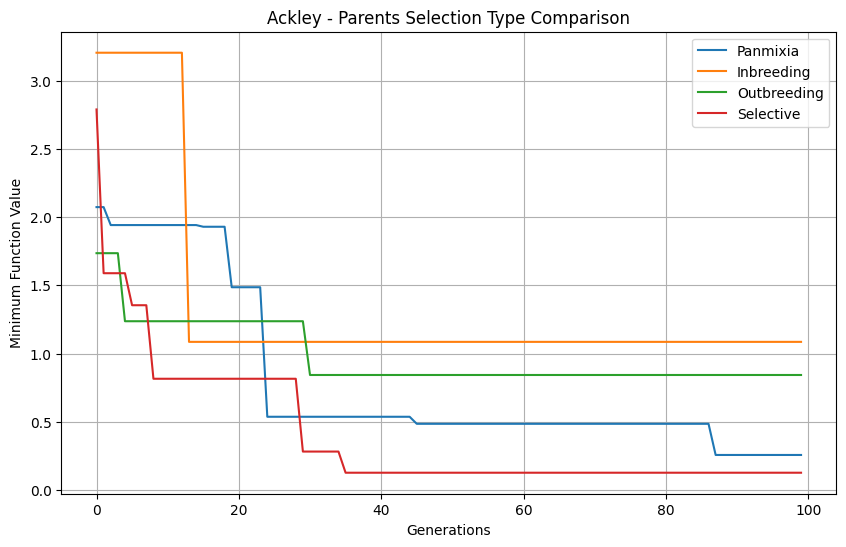

In [77]:
fitness_histories = [
    ackley_parents["Panmixia"]["Fitness History"],
    ackley_parents["Inbreeding"]["Fitness History"],
    ackley_parents["Outbreeding"]["Fitness History"],
    ackley_parents["Selective"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Panmixia", "Inbreeding", "Outbreeding", "Selective"],
    title="Ackley - Parents Selection Type Comparison",
)

<h3>Three-hump Camel

In [78]:
camel_parents = test_parents(camel, LIMITS["Three-Hump Camel"])
print(f"{'Parents Selection':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for parents_type, result in camel_parents.items():
    print(
        f"{parents_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Iteration 1: Best Fitness = 0.41200007025945723, Solution = [-0.3611047531853204, 0.6292057679102765]
Iteration 2: Best Fitness = 0.3846888295113249, Solution = [-1.741741054398413, 1.1638818951705199]
Iteration 3: Best Fitness = 0.3846888295113249, Solution = [-1.741741054398413, 1.1638818951705199]
Iteration 4: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 5: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 6: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 7: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 8: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 9: Best Fitness = 0.11536633991738567, Solution = [-0.19645990691996662, -0.12397955291065887]
Iteration 10: Best Fitness = 0.11536633991738567, Solution = [-0.196

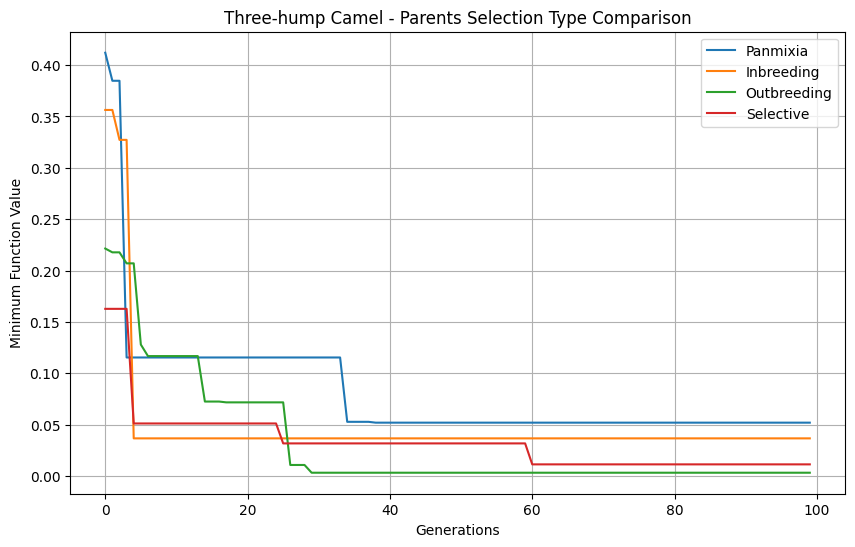

In [79]:
fitness_histories = [
    camel_parents["Panmixia"]["Fitness History"],
    camel_parents["Inbreeding"]["Fitness History"],
    camel_parents["Outbreeding"]["Fitness History"],
    camel_parents["Selective"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Panmixia", "Inbreeding", "Outbreeding", "Selective"],
    title="Three-hump Camel - Parents Selection Type Comparison",
)

<h2>Children Selection

In [88]:
# Function to test crossover types
def test_children(func, limits, pop_size=100):
    results = {}

    # simple selection
    start_time = time.time()
    best_solution_ss, fitness_history_ss = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="SS",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_ss = time.time() - start_time

    results["Simple"] = {
        "Best Solution": best_solution_ss,
        "Time Taken (s)": execution_time_ss,
        "Fitness History": fitness_history_ss,
    }

    # displacemest selection
    start_time = time.time()
    best_solution_ds, fitness_history_ds = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="SD",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_ds = time.time() - start_time

    results["Displacement"] = {
        "Best Solution": best_solution_ds,
        "Time Taken (s)": execution_time_ds,
        "Fitness History": fitness_history_ds,
    }

    # elite selection
    start_time = time.time()
    best_solution_es, fitness_history_es = genetic_algorithm(
        func,
        limits=limits,
        pop_size=pop_size,
        max_iterations=100,
        crossover_type="SP",
        mutation_rate=0.01,
        inversion_rate=0.05,
        parent_selection_method="SE",
        population_formation="ES",
        stopping_type="fixed",
        stop_threshold=0.01,
    )
    execution_time_es = time.time() - start_time

    results["Elite"] = {
        "Best Solution": best_solution_es,
        "Time Taken (s)": execution_time_es,
        "Fitness History": fitness_history_es,
    }

    return results

In [89]:
easom_children = test_children(easom, LIMITS["Easom"])
print(f"{'Children Selection':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for children_type, result in easom_children.items():
    print(
        f"{children_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Overall Best Solution: [4.338139925230806, 4.521248187991162] with Fitness = -0.0024730482138696133
----------------------------------------------------------------------------------------------------


Overall Best Solution: [1.7532616159304126, 3.425650415808363] with Fitness = -0.02338170884751354
----------------------------------------------------------------------------------------------------


Overall Best Solution: [0.34637979705500754, 6.684977492942707] with Fitness = -1.2339954906512578e-09
----------------------------------------------------------------------------------------------------


Children Selection Best Solution        Time Taken (s)    
Simple          -0.0024730482138696133 3.804730176925659
Displacement    -0.02338170884751354 2.06978178024292
Elite           -1.2339954906512578e-09 1.2073721885681152


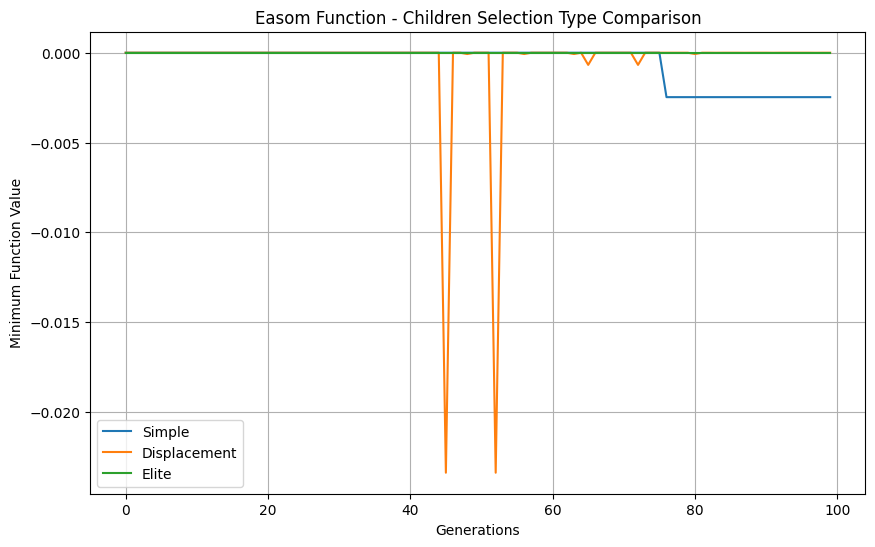

In [90]:
fitness_histories = [
    easom_children["Simple"]["Fitness History"],
    easom_children["Displacement"]["Fitness History"],
    easom_children["Elite"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Simple", "Displacement", "Elite"],
    title="Easom Function - Children Selection Type Comparison",
)

In [91]:
ackley_children = test_children(ackley, LIMITS["Ackley"])
print(f"{'Children Selection':<15} {'Best Solution':<20} {'Time Taken (s)':<18}")
for children_type, result in ackley_children.items():
    print(
        f"{children_type:<15} {result['Best Solution']:<20} {result['Time Taken (s)']:<15}"
    )

Overall Best Solution: [-0.04188601510643153, -0.018081940947585196] with Fitness = 0.18361997219902548
----------------------------------------------------------------------------------------------------


Overall Best Solution: [0.0029755092698557917, -0.02662699320973516] with Fitness = 0.09478456928086842
----------------------------------------------------------------------------------------------------


Overall Best Solution: [0.029678797589074435, 0.032120241092545854] with Fitness = 0.1739826925062964
----------------------------------------------------------------------------------------------------


Children Selection Best Solution        Time Taken (s)    
Simple          0.18361997219902548  4.696116209030151
Displacement    0.09478456928086842  2.6602814197540283
Elite           0.1739826925062964   2.0634262561798096


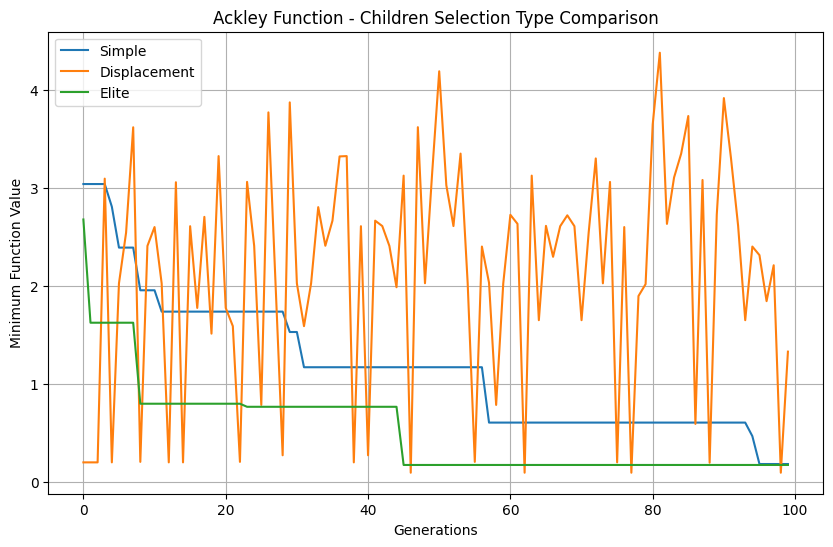

In [94]:
fitness_histories = [
    ackley_children["Simple"]["Fitness History"],
    ackley_children["Displacement"]["Fitness History"],
    ackley_children["Elite"]["Fitness History"],
]

plot_fitness_history(
    fitness_histories,
    labels=["Simple", "Displacement", "Elite"],
    title="Ackley Function - Children Selection Type Comparison",
)